# WATER BAG TIME SERIE CLASSIFICATION - Preliminar Evaluation

---
## Define Functions

#### Change project root directory

In [1]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


#### Import modules and libraries

In [2]:
import os, json, pandas as pd, numpy as np, pickle
import matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

#### Time serie features transformation pipeline & binary classification pipeline (Authoral)
from Modulos.timeserie_transform import TimeseriesTransformPipeline
from Modulos.imbalanced_selection import groupConsecutiveFlags, MinorityGroupSplitUndersample

#### Preprocessing & machine learning modules
from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms, PowerTransformer as pt
from sklearn.model_selection import cross_validate, cross_val_predict
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.utils import all_estimators
classifiers = dict(all_estimators('classifier'))
# from Modulos.cv_samplers import GroupUnderSampleSplit, print_cls_cnt

#### Metrics and scoring functions
from sklearn.metrics import (
    make_scorer, recall_score, precision_score,
    f1_score, precision_recall_fscore_support,
    classification_report as cr
)
recall_0 = make_scorer(recall_score, pos_label=0)
recall_1 = make_scorer(recall_score, pos_label=1)
precision_0 = make_scorer(precision_score, pos_label=0)
precision_1 = make_scorer(precision_score, pos_label=1)
f1_0 = make_scorer(f1_score, pos_label=0)
f1_1 = make_scorer(f1_score, pos_label=1)

scoring = {
    'accuracy': 'accuracy',
    'recall': 'recall', 'precision': 'precision',
    'recall-0': recall_0, 'recall-1': recall_1,
    'precision-0': precision_0, 'precision-1': precision_1,
    'f1-0': f1_0, 'f1-1': f1_1
}

C:\Users\luisr\AppData\Roaming\Python\Python38\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


## Utility Funcitons

In [34]:
from sklearn.preprocessing import LabelEncoder as le

def custom_preprocessing(X, drop_empty_cols=True, label_encode=None, interpolate='linear', fillna='mean'):

    print('Initial shape:', X.shape)

    if drop_empty_cols: # Drop X empty columns and rows
        X.dropna(axis=1, how='all', inplace=True)
        print('Empty columns removed: ', X.shape)

    if label_encode is not None:
        print('Label columns encoded:', list(label_encode))
        for col in label_encode:
            X[col] = le().fit_transform(X[col])

    if interpolate is not None: # Interpolate X missing values
        print('Interpolation:', interpolate)
        X = X.interpolate(interpolate)

    if fillna is not None: # Fill missing values with the minimum column value
        print('Fill missing values:', fillna)
        for col in X:
            if fillna=='min':
                fill_value = X[col].min()
            elif fillna=='mean':
                fill_value = X[col].mean()
            else:
                fill_value = 0
            X[col].fillna(fill_value, inplace=True)

    return X

# Target selection and train/test split
def select_target(target_id, periods_ahead):
    print(f'Selected Target: {target_names[int(target_id)]} - id: {target_id}', '\n')

    # Select target
    Y = Yi[str(target_id)].loc[X.index].copy()
    display(Y.value_counts().to_frame('Target'))

    ### Target transformation
    if periods_ahead is not None:
        Y = (Y.rolling(periods_ahead, closed='left', min_periods=1).sum().shift(-periods_ahead + 1) > 0).astype('float')
        display(Y.value_counts().to_frame('Target Transformed'))

    # Group target positive class labels by being consecutive in time (group evaluation strategy)
    groups = groupConsecutiveFlags(ts=Y)
    
    return Y, groups

from sklearn.metrics import classification_report as cr, precision_recall_curve

# Classification report for test probabilities for given threshold
def clf_score(ye, yprob, threshold=0.5):
    yhat = (yprob > threshold).astype('int')
    scr = pd.DataFrame(cr(ye, yhat, digits=4, output_dict=True)).T
    return scr

# Precision-recall curve plot for test probabilities for given threshold
def precision_recall_plot(ye, yprob, thresh_lim=None, recall_lim=None):
    curve = pd.DataFrame(
        precision_recall_curve(ye, yprob, pos_label=1),
        index=['precision', 'recall', 'threshold']
    ).T.set_index('threshold').add_suffix(f' - 1')
    curve['f1 - 1'] = curve.mean(1)
    prec, rec = curve['precision - 1'], curve['recall - 1']
    curve['harmonic mean - 1'] = 2 * prec * rec / (prec + rec)
    fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))
    curve.plot(ax=ax[0]); curve.reset_index().plot('recall - 1', ['precision - 1', 'f1 - 1', 'harmonic mean - 1'], ax=ax[1])
    ax[0].set(title='Precision-Recall by Threshold', xlim=thresh_lim); ax[1].set(title='Precision-Recall Curve', xlim=recall_lim)
    return ax

---
## Load & Preprocess Data

In [4]:
from Modulos.waterbags import waterbag_project

project = waterbag_project(time_serie='clusters', freq='upsample', load_waterbags=True, time_features=True)

data = project.data.drop('index', axis=1)
Yi = project.time_serie
waterbags = project.waterbags

# Sample groups names per group label
target_names = waterbags.groupby(['sublabel', 'main_route']).first().index.to_frame().set_index('sublabel').to_dict()['main_route']

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO\Modulos\waterbags.py:63: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  upsample = inmet.resample('15Min').pad()


---
# 1. Preprocessing & Data Transformation

### Target rolling proportion

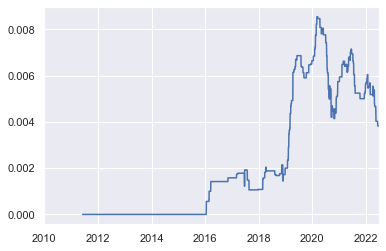

In [24]:
Yi['1'].rolling(50000).mean().plot()

### Feature set

In [35]:
train_start, train_end = '2018-06', '2020-07'
eval_start, eval_end = '2020-08', '2022-04'

transform_args = dict(
    drop_empty_cols=True,
    label_encode=data.columns[:11],
    interpolate='linear', fillna='mean'
)

X = custom_preprocessing(data[train_start: eval_end].copy(), **transform_args)

# Validation split
xt = X[train_start: train_end]
xe = X[eval_start: eval_end]

Initial shape: (137280, 241)
Empty columns removed:  (137280, 228)
Label columns encoded: ['year', 'month', 'day', 'hour', 'minute', 'date', 'time', 'dayofyear', 'weekofyear', 'weekday', 'quarter']
Interpolation: linear
Fill missing values: mean


### Target variable

In [36]:
target_id = '1'
periods_ahead = 4

Y, groups = select_target(target_id, periods_ahead)

# Target validation split
yt = Y.loc[xt.index]
ye = Y.loc[xe.index]
groups_train = groups.loc[xt.index]
groups_eval = groups.loc[xe.index]

eval_p = (ye.value_counts() / Y.value_counts() * 100)
display(eval_p.round(2).to_frame('Validation (%)'))

Selected Target: Rua do Catete - id: 1 



,Target
0.0,136497
1.0,783


,Target Transformed
0.0,136283
1.0,997


,Validation (%)
0.0,44.62
1.0,44.53


---
# 2. Time Series Classification - Preliminary modeling

In [232]:
from sklearn.linear_model import LinearRegression as lr

seed = 0

gbc = classifiers['GradientBoostingClassifier']
sgd = classifiers['SGDClassifier']
logistic = classifiers['LogisticRegression']
lda = classifiers['LinearDiscriminantAnalysis']
qda = classifiers['QuadraticDiscriminantAnalysis']
SVC = classifiers['SVC']
LinearSVC = classifiers['LinearSVC']

# Initialize model

# model = gbc(n_estimators=20, random_state=0, verbose=1)
model = sgd(
    loss='hinge', penalty='l1',
    alpha=0.0001, l1_ratio=0.15, # l1_ratio only used if penalty is elasticnet
    early_stopping=True, n_iter_no_change=5,
    validation_fraction=0.1, tol=0.000001, max_iter=20,
    class_weight=None, average=False,
    random_state=seed, verbose=0, n_jobs=-1,
)

# model = qda()

---
# 3. Transformation pipelines

## Scale pipeline

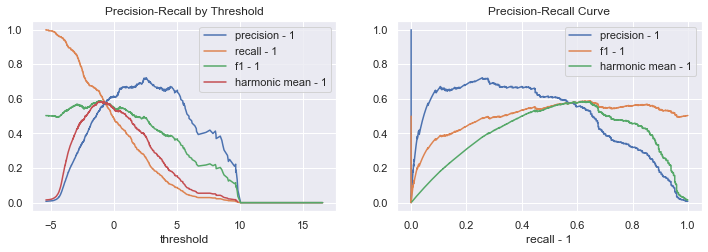

,precision,recall,f1-score,support
0.0,0.996272,0.997747,0.997009,60804.000000
1.0,0.612994,0.488739,0.543860,444.000000
accuracy,0.994057,0.994057,0.994057,0.994057
macro avg,0.804633,0.743243,0.770434,61248.000000
weighted avg,0.993494,0.994057,0.993724,61248.000000


In [233]:
# Pipeline
pipe = Pipeline([('scale', mms()), ('model', model)])

### Fit and predict
pipe.fit(xt, yt)
# yprob = pipe.predict_proba(xe)[:, 1]
yprob = pipe.decision_function(xe)
# yprob = model.predict(xe)

### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
scr = clf_score(ye, yprob, 0.0)
plt.show(); display(scr)

### Feature importance

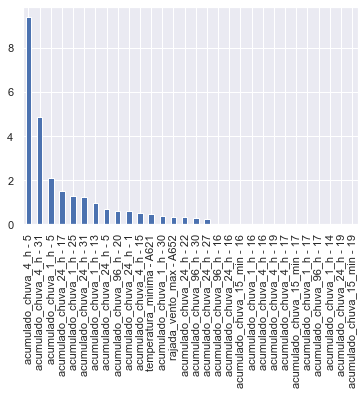

In [234]:
fi = pd.Series(pipe[1].coef_[0], index=xt.columns).sort_values(ascending=False)

fi.head(30).plot.bar()

## Feature selection pipeline

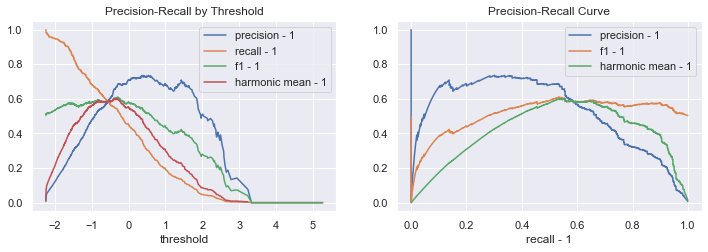

,precision,recall,f1-score,support
0.0,0.995998,0.998651,0.997323,60804.000000
1.0,0.709220,0.450450,0.550964,444.000000
accuracy,0.994677,0.994677,0.994677,0.994677
macro avg,0.852609,0.724551,0.774144,61248.000000
weighted avg,0.993919,0.994677,0.994087,61248.000000


In [269]:
from sklearn.feature_selection import SelectFromModel, SelectKBest

selector = SelectKBest(k=15)
# selector = SelectFromModel(pipe[1], prefit=False, threshold='mean').fit(xt, yt)

# Pipeline
pipe = Pipeline([('scale', mms()), ('feature selection', selector), ('model', model)])

### Fit and predict
pipe.fit(xt, yt)
# yprob = pipe.predict_proba(xe)[:, 1]
yprob = pipe.decision_function(xe)

### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
scr = clf_score(ye, yprob, 0.0)
plt.show(); display(scr)

### Selector importance

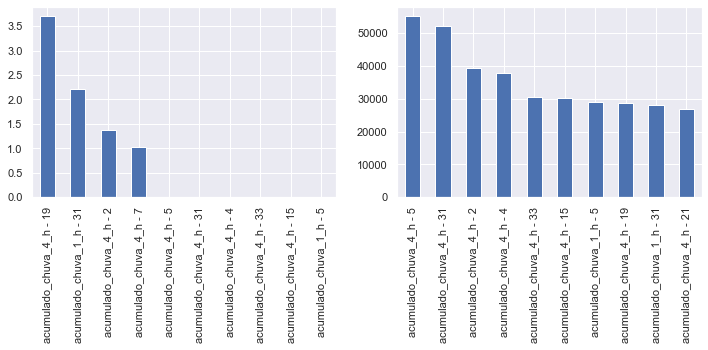

In [270]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))

sel_scr = pd.Series(pipe[1].scores_, index=xt.columns).sort_values(ascending=False)
model_fi = pd.Series(pipe[2].coef_[0], index=xt[sel_scr.index[:15]].columns).sort_values(ascending=False)

model_fi.head(10).plot.bar(ax=ax[0])
sel_scr.head(10).plot.bar(ax=ax[1])

## Undersample pipeline

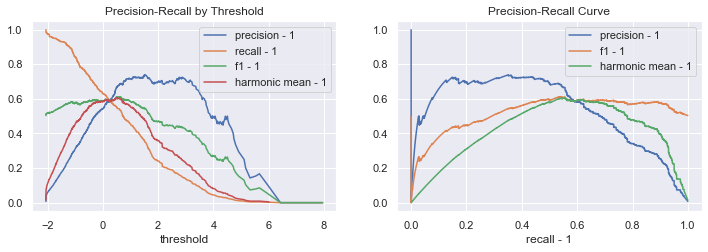

,precision,recall,f1-score,support
0.0,0.997300,0.996135,0.996717,60804.000000
1.0,0.543689,0.630631,0.583942,444.000000
accuracy,0.993486,0.993486,0.993486,0.993486
macro avg,0.770494,0.813383,0.790329,61248.000000
weighted avg,0.994011,0.993486,0.993725,61248.000000


In [1001]:
train_prct = 0.015
selector = SelectKBest(k=10)

# Undersampler instance
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)

# Pipeline
pipe = Pipeline([('scale', mms()), ('feature selection', selector), ('under', rus), ('model', model)])

### Fit and predict
pipe.fit(xt, yt)
# yprob = pipe.predict_proba(xe)[:, 1]
yprob = pipe.decision_function(xe)

### Evaluate prediction
ax = precision_recall_plot(ye, yprob)
scr = clf_score(ye, yprob, 0.0)
plt.show(); display(scr)

---
# 4. KFold cross-validation

In [296]:
scr_cols = ['train_precision-1', 'train_recall-1', 'train_f1-1', 'test_precision-1', 'test_recall-1', 'test_f1-1']
stats_cols = ['mean', 'std', 'min', '50%', 'max']

pipe

Pipeline(steps=[('scale', MinMaxScaler()),
                ('under',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.008)),
                ('model',
                 SGDClassifier(early_stopping=True, max_iter=20, n_jobs=-1,
                               penalty='l1', random_state=0, tol=1e-06))])

### Minority group kfold split

In [289]:
splitter = MinorityGroupSplitUndersample(
    n_splits=10,
#     train_size=0.80, test_size=0.19,      # Not used if split strategy is GroupKFold
    train_prct=None, test_prct='natural',
    random_state=seed,
)
strategy='GroupKFold'

cv_group = splitter.split(xt, yt, groups_train, strategy)

### Cross validation score

In [288]:
# evaluate splits
scr_group =  pd.DataFrame(cross_validate(
    pipe, xt, yt, groups=groups_train,
    scoring=scoring, cv=cv_group,
    n_jobs=-1, verbose=5,
    pre_dispatch='2*n_jobs',
    return_train_score=True,
))

In [297]:
scr_group[scr_cols].describe().loc[stats_cols]

,train_precision-1,train_recall-1,train_f1-1,test_precision-1,test_recall-1,test_f1-1
mean,0.718764,0.670509,0.692941,0.621044,0.614451,0.614336
std,0.019620,0.034220,0.014315,0.025742,0.112703,0.071490
min,0.685885,0.587174,0.656215,0.580000,0.388889,0.466667
50%,0.716889,0.676426,0.696058,0.627885,0.632357,0.629121
max,0.752294,0.704819,0.707194,0.655738,0.745455,0.689655


---
# 5. Time series split cross-validation

In [275]:
from sklearn.model_selection import TimeSeriesSplit

period_mean = Y.resample('Q').mean().to_frame('True Period Average - Normalized')
period_mean.iloc[:, 0] = mms().fit_transform(period_mean)
n_periods = period_mean.shape[0]; n_periods

17

### Time series based split pipeline

In [960]:
n_splits = n_periods * 2
max_train_size = 1 * 365 * 24 * 4

splitter = TimeSeriesSplit(n_splits, max_train_size=max_train_size, test_size=None)
cv_time = list(splitter.split(X, Y))

train_prct = 0.012

# Undersampler instance
rus = RandomUnderSampler(sampling_strategy=train_prct, random_state=seed)

# Pipeline
pipe = Pipeline([('scale', mms()), ('features', SelectKBest(k=15)), ('under', rus), ('model', model)])

##### Note: In order to always predict on entire remaining test samples, split test folders can be summed up from right to left

### Cross-validation score

In [961]:
# evaluate splits
scr_time = pd.DataFrame(cross_validate(
    pipe, X.values, Y.values, # groups=groups_train,
    scoring=scoring, cv=cv_time,
    return_train_score=True,
    error_score=np.nan,
    n_jobs=-1, verbose=5,
    pre_dispatch='2*n_jobs',
))

# Reset score index by split test index start
test_start = []
for train, test in cv_time:
    test_start.append(X.iloc[test].index.min())
scr_time.index = test_start

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   11.1s finished


In [965]:
# Test class proportion
mean_1 = pd.DataFrame(
    mms().fit_transform([[Y[cv[1]].mean()] for cv in cv_time]),
    columns=['test_support-1 normalized'], index=scr_time.index
)

not_null = mean_1.iloc[:, 0]!=0

### Temporal performance

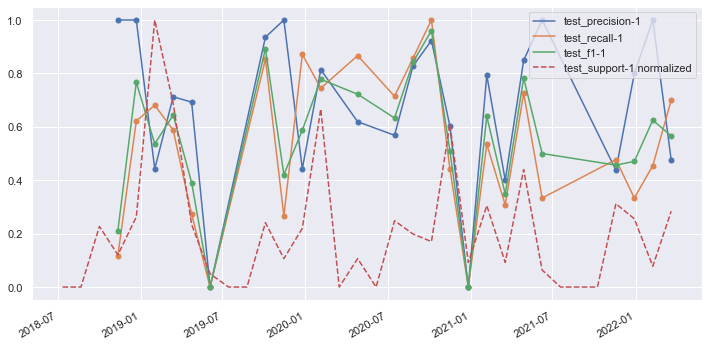

In [966]:
ax = scr_time[not_null][scr_cols[3:6]].plot(marker='o', ms=5, figsize=(12, 6))
ax = mean_1.plot(ax=ax, linestyle='--')

### Average temporal performance

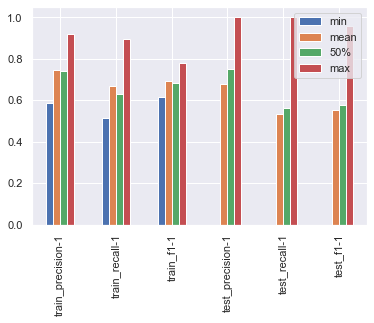

In [967]:
scr_time[not_null].describe().loc[['min', 'mean', '50%', 'max'], scr_cols].T.plot.bar()

---
# Time serie split probability predictions - visualization

In [968]:
def scale_proba(yprob, threshold, limit=(0, 1)):
    yprob = yprob.copy()
    if limit is not None:
        yprob[yprob < limit[0]] = limit[0]
        yprob[yprob > limit[1]] = limit[1]
    msk = yprob >= threshold
    yprob[~msk] = mms((0, 0.49999999)).fit_transform(yprob[~msk].to_frame()).reshape(-1)
    yprob[msk] = mms((0.5, 1)).fit_transform(yprob[msk].to_frame()).reshape(-1)
    return yprob

### Time series based split

In [969]:
# n_splits = n_periods

# cv_time = list(splitter.split(X, Y))

### Concatenated splits' probabilities

In [970]:
scale = True

yprob_cv = []
for i, (train, test) in enumerate(cv_time):
    try:
        pipe.fit(X.iloc[train], Y.iloc[train])
        try:
            yprob = pipe.predict_proba(X.iloc[test])[:, 1]; thresh = 0.5
        except:
            yprob = pipe.decision_function(X.iloc[test]); thresh = 0.0
        # Optional scale probabilities
        if scale: yprob = scale_proba(pd.Series(yprob), threshold=thresh, limit=None).values

        yprob_cv.append(yprob)
    except Exception as e:
        yprob_cv.append(np.array([np.nan for i in range(len(test))]))
#         print('Error:', e)
    co(True); print(f'cv: {i+1}/{len(cv_time)}')

min_test_time = cv_time[0][1][0]
yprob_cv = pd.Series(np.concatenate(yprob_cv), index=X.index[min_test_time:]).dropna()

ye_cv = Y.loc[yprob_cv.index]
groups_cv = groups.loc[ye_cv.index]

cv: 34/34


### Probability time serie plot

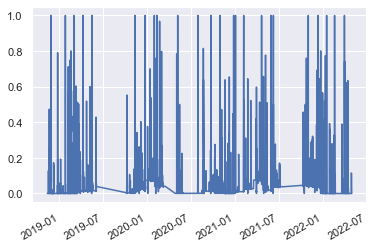

In [971]:
ax = yprob_cv.plot()

### Threshold-moving evaluation

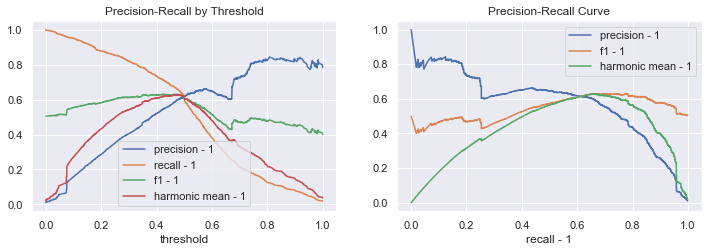

,precision,recall,f1-score,support
0.0,0.995837,0.996243,0.996040,93170.00000
1.0,0.619565,0.594990,0.607029,958.00000
accuracy,0.992160,0.992160,0.992160,0.99216
macro avg,0.807701,0.795616,0.801535,94128.00000
weighted avg,0.992008,0.992160,0.992081,94128.00000


In [972]:
ax = precision_recall_plot(ye_cv, yprob_cv, thresh_lim=None)
scr = clf_score(ye_cv, yprob_cv, 0.5)
plt.show(); display(scr)

### Cut and scale probabilities

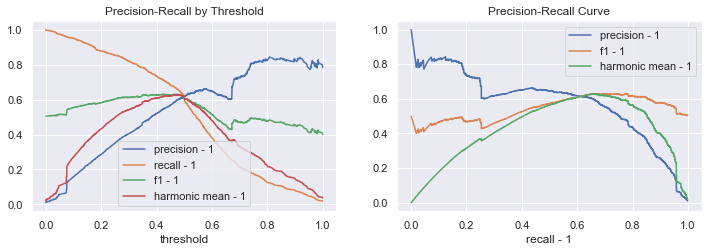

,precision,recall,f1-score,support
0.0,0.995837,0.996243,0.996040,93170.00000
1.0,0.619565,0.594990,0.607029,958.00000
accuracy,0.992160,0.992160,0.992160,0.99216
macro avg,0.807701,0.795616,0.801535,94128.00000
weighted avg,0.992008,0.992160,0.992081,94128.00000


In [973]:
yprob_scl = scale_proba(yprob_cv, threshold=0.5, limit=None)

ax = precision_recall_plot(ye_cv, yprob_scl)
scr = clf_score(ye_cv, yprob_scl, 0.5)
plt.show(); display(scr)

### Temporal performance

#### Obs: Suppost to work with regular or scaled probs???   *****

#### Score per period - Single or cumulative

In [974]:
threshold = 0.5
cumulative = True
dates = pd.date_range(yprob_cv.index.min(), yprob_cv.index.max(), freq='M')

scr_names = ['precision-1', 'recall-1', 'f1-score-1', 'support-1']
labels = ['0.0', '1.0']

scrs_date = []
for date in dates:
    yprob_bin = yprob_scl[:date]
    ye_bin = ye_cv.loc[yprob_bin.index]
    scr = clf_score(ye_bin, yprob_bin, threshold)
    for label in labels:
        if label not in scr.index: scr.loc[label] = [np.nan, np.nan, np.nan, 0.0]
    scr_flat = pd.concat([scr.loc[label].add_suffix('-'+label[0]) for label in labels])
    scrs_date.append(scr_flat)
scrs_date = pd.DataFrame(scrs_date, index=dates)

#### Cumulative score per period

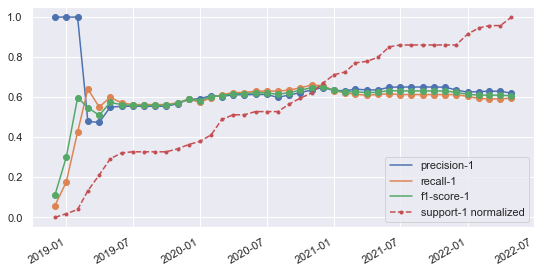

In [975]:
support_norm = pd.DataFrame(
    mms().fit_transform(scrs_date[[scr_names[-1]]]).reshape(-1),
    index=scrs_date.index,
    columns=['support-1 normalized']
)
ax = scrs_date[scr_names[:-1]].iloc[:].plot(figsize=(9, 4.5), marker='o')
ax = support_norm.plot(ax=ax, ls='--', marker='.')

#### Next steps

1. Predict larger time span and/or multiple intervals (perhaps optimize)
1. Test time series classification algorithms
1. New data (satelite + waze)

---
# Group performance

In [1027]:
def group_recall(y, yhat, grps, metric='recall-1'):
    grp_df = []
    for group in grps.unique():
        if group != -1:
            msk = grps==group
            grp_acc = (y[msk] == yhat[msk]).mean()
            grp_df.append([group, grp_acc, int(grp_acc > 0.0)])        
    return pd.DataFrame(grp_df, columns=['label', metric, metric + ' group']).set_index('label')


def group_precision_recall_stats(ye, yhat, groups, groups_hat):

    grp_df = group_recall(ye, yhat, groups)
    pred_df = group_recall(ye, yhat, groups_hat, metric='precision-1')

    print('Target groups:', grp_df.shape[0], '\n')
    display(grp_df.mean())
    print('\nPrediction groups:', pred_df.shape[0], '\n')
    display(pred_df.mean())

    fig, ax = plt.subplots(1, 2, figsize=(11, 3))
    ax[0] = grp_df['recall-1'].plot.hist(ax=ax[0], title='Group Recall')
    ax[1] = pred_df['precision-1'].plot.hist(ax=ax[1], title='Group Precision')
    return ax

def group_precision_recall(y, yhat, groups_y, groups_hat):

    ### Inside groups
    grp_df = group_recall(y, yhat, groups_y).mean()
    grp_df['support-1'] = len(groups_y.unique()) - 1

    ### Inside positive predictions
    pred_df = group_recall(y, yhat, groups_hat, metric='precision-1').mean()
    pred_df['support-1 group'] = len(groups_hat.unique()) - 1
    
    return (df.add_suffix(' avg') for df in (grp_df, pred_df))

def group_precision_recall_curve(y, yprob, groups_y, num=20):

    thresholds = np.linspace(yprob.min(), yprob.max(), num)
    grp_tunning, pred_tunning = [], []
    for thresh in thresholds:

        #### Probability prediction and groups
        yhat = (yprob > thresh).astype('int')
        groups_hat = groupConsecutiveFlags(ts=yhat)

        grp_df, pred_df = group_precision_recall(y, yhat, groups_y, groups_hat)
        
        grp_tunning.append(pd.concat([grp_df, pred_df], axis=0))

    grp_curve = pd.DataFrame(grp_tunning, index=thresholds)
    grp_curve['f1-1 avg'] = grp_curve[['precision-1 avg', 'recall-1 avg']].mean(1)
    grp_curve['f1-1 group avg'] = grp_curve[['precision-1 group avg', 'recall-1 group avg']].mean(1)
    
    return grp_curve

def group_precision_recall_plot(y, yprob, groups_y, num=20):

    avg_cols = ['precision-1 avg', 'recall-1 avg', 'f1-1 avg']
    group_cols = ['precision-1 group avg', 'recall-1 group avg', 'f1-1 group avg']

    grp_curve = group_precision_recall_curve(y, yprob, groups_y, num)    

    fig, ax = plt.subplots(2, 2, figsize=(12, 7), sharey=True)
    grp_curve.plot(y=avg_cols, ax=ax[0][0])
    grp_curve.plot(x='recall-1 avg', y=['precision-1 avg', 'f1-1 avg'], ax=ax[0][1])
    grp_curve.plot(y=group_cols, ax=ax[1][0])
    grp_curve.plot(x='recall-1 group avg', y=['precision-1 group avg', 'f1-1 group avg'], ax=ax[1][1])
    return ax, grp_curve

## Group scoring

Target groups: 68 



recall-1          0.503519
recall-1 group    0.794118
dtype: float64


Prediction groups: 94 



precision-1          0.576147
precision-1 group    0.638298
dtype: float64

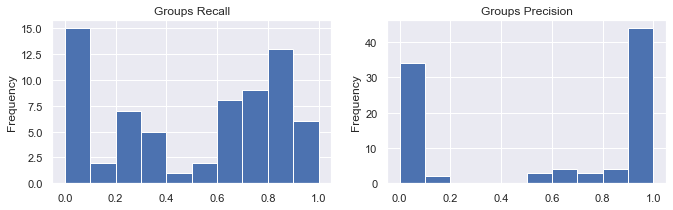

In [977]:
yhat_scl = (yprob_scl > 0.5).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat_scl)

ax = group_precision_recall_stats(ye_cv, yhat_scl, groups_cv, groups_hat)

## Threshold-moving group performance

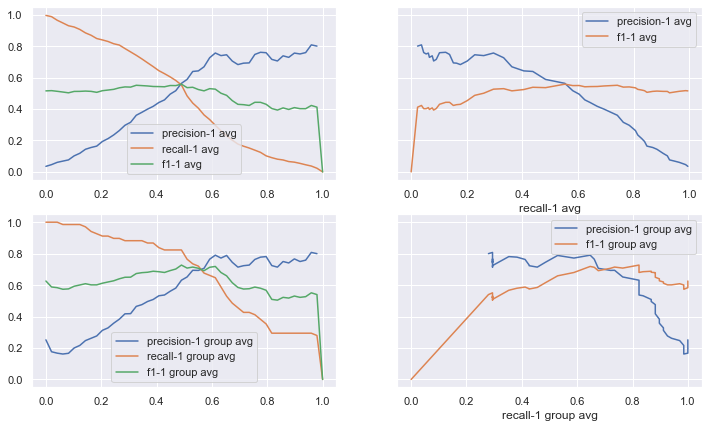

In [978]:
ax, grp_curve = group_precision_recall_plot(ye_cv, yprob_scl, groups_cv, num=50)

### Predicted groups count

In [992]:
avg_cols = ['precision-1 avg', 'recall-1 avg', 'f1-1 avg']
group_cols = ['precision-1 group avg', 'recall-1 group avg', 'f1-1 group avg']

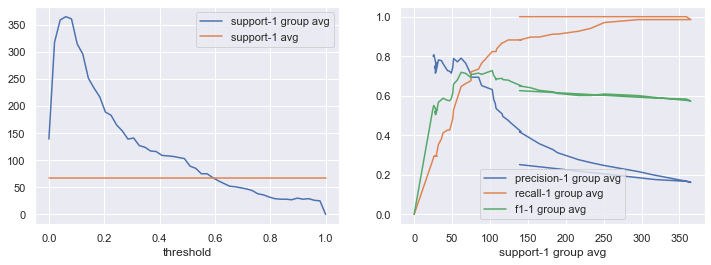

In [998]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

grp_curve[['support-1 avg']].plot(xlabel='threshold', ax=ax[0], label='')
grp_curve[['support-1 group avg']].plot(xlabel='threshold', ax=ax[0])
ax = grp_curve.set_index('support-1 group avg')[group_cols].plot(ax=ax[1])

### Selected threshold

Selected threshold: 0.6


Target groups: 68 



recall-1          0.315444
recall-1 group    0.661765
dtype: float64


Prediction groups: 65 



precision-1          0.740716
precision-1 group    0.784615
dtype: float64

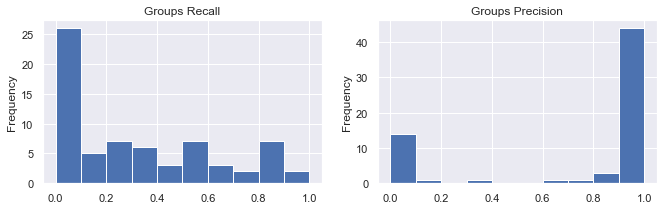

In [979]:
sel_thresh = float(input('Selected threshold:'))

yhat_scl = (yprob_scl > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat_scl)

ax = group_precision_recall_stats(ye_cv, yhat_scl, groups_cv, groups_hat)

### Final validation

In [999]:
pipe.fit(xt, yt)

Pipeline(steps=[('scale', MinMaxScaler()), ('features', SelectKBest(k=15)),
                ('under',
                 RandomUnderSampler(random_state=0, sampling_strategy=0.012)),
                ('model',
                 SGDClassifier(early_stopping=True, max_iter=20, n_jobs=-1,
                               penalty='l1', random_state=0, tol=1e-06))])

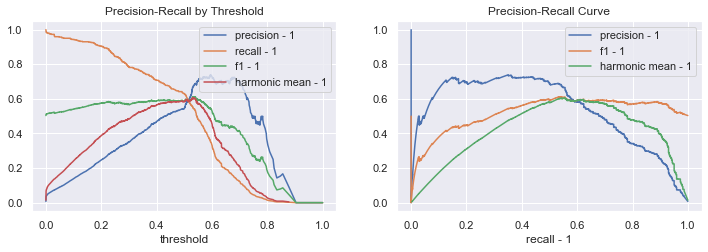

,precision,recall,f1-score,support
0.0,0.999877,0.801559,0.889802,60804.0000
1.0,0.035029,0.986486,0.067655,444.0000
accuracy,0.802900,0.802900,0.802900,0.8029
macro avg,0.517453,0.894023,0.478728,61248.0000
weighted avg,0.992883,0.802900,0.883842,61248.0000


In [1019]:
# yprob = pipe.predict_proba(xe)[:, 1]
yprob = pd.Series(pipe.decision_function(xe), index=ye.index)
yprob = scale_proba(yprob, 0., limit=None)

### Evaluate prediction
ax = precision_recall_plot(ye, yprob, None)
scr = clf_score(ye, yprob, 0.0)
plt.show(); display(scr)

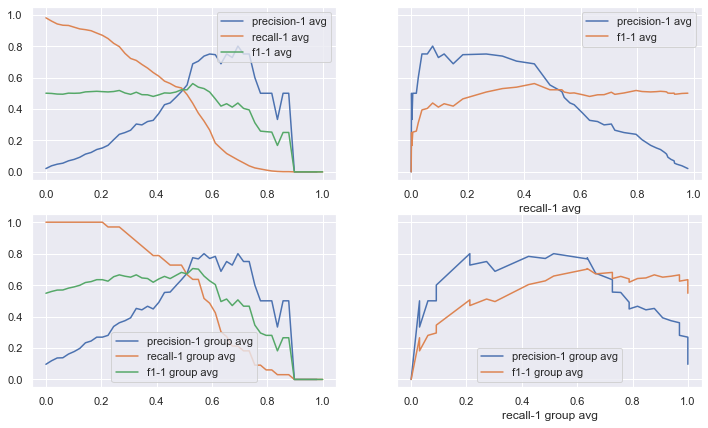

In [1021]:
ax, grp_curve = group_precision_recall_plot(ye, yprob, groups_eval, num=50)

Selected threshold: 0.55


Target groups: 33 



recall-1          0.373261
recall-1 group    0.636364
dtype: float64


Prediction groups: 31 



precision-1          0.681647
precision-1 group    0.741935
dtype: float64

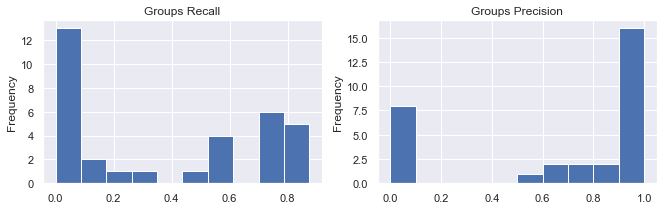

In [1026]:
sel_thresh = float(input('Selected threshold:')); print()

yhat = (yprob > sel_thresh).astype('int')
groups_hat = groupConsecutiveFlags(ts=yhat)

ax = group_precision_recall_stats(ye, yhat, groups_eval, groups_hat)

# Probability windows

#### Conclusions

##### Trends:
1. Not identified events
1. high probability in the middle of event
1. After start of event
1. Before start of event
1. After end of event

In [940]:
def groups_windows(groups, spread=6, freq=pd.Timedelta(1, 'h')):
    windows = []; wide = spread * freq
    for group in groups.unique():
        group_index = groups.index[groups==group]
        grp_min, grp_max = group_index.min(), group_index.max()
        windows.append((grp_min - wide, grp_max + wide))
    return windows

def window_prob(ye, yprob, time_lim, ax=None):
    yprob = pd.Series(mms().fit_transform(yprob.to_frame()).reshape(-1), index=yprob.index) # scale probability to 0-1 range
    msk = ye.index.to_series().between(*time_lim) # time window limits
    if ax is None: ax = plt.axes()
    yprob[msk].plot(ax=ax)
    ax = ye[msk].plot(ax=ax)
    return ax

def multi_window_prob(ye, yprob, windows, n_cols, title='Probability {} - {}', path=None):
    n_plots = len(windows)
    n_rows = int(n_plots / n_cols if n_plots % n_cols == 0 else n_plots // n_cols + 1)
    figsize = (6 * n_cols, 4 * n_rows)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, tight_layout=True, sharey=True)
    axs = list(axs.reshape(-1))
    i=0
    for ax, time_lim in zip(axs, windows):
        i+=1; co(wait=True); print(f'{i}/{len(windows)}')
        msk = ye.index.to_series().between(time_lim[0], time_lim[1]) # time window limits
        yprob[msk].plot(ax=ax)
        ye[msk].plot(ax=ax)
        time_min, time_max = (time_lim[j].strftime('%d-%h-%y %H:%m') for j in (0, 1))
        ax.set(title=title.format(time_min, time_max))
    if path is not None: plt.savefig(path)
    return fig, axs

### Positive class probabilities

67/67


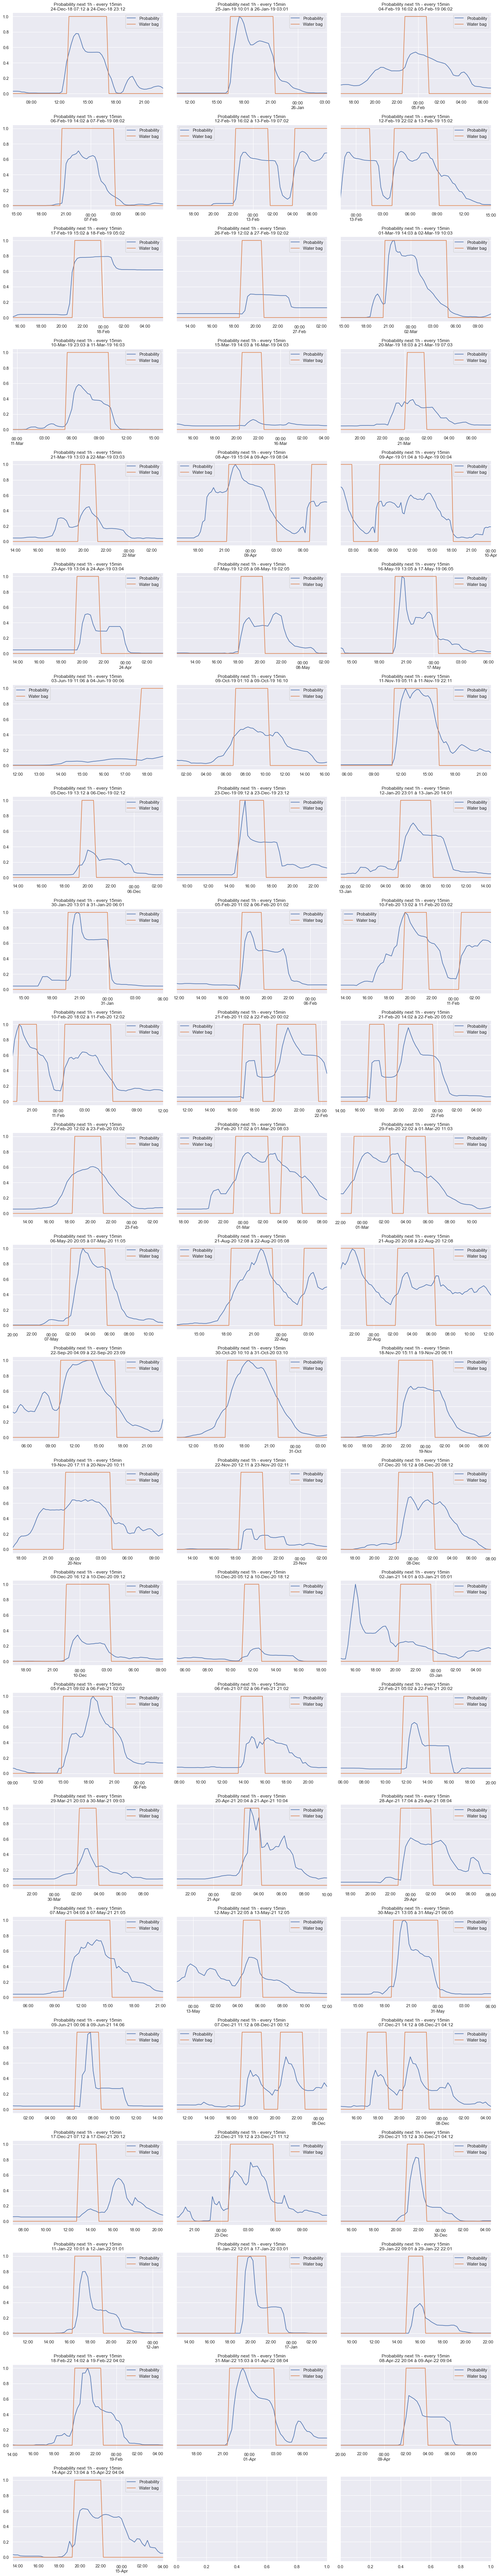

In [938]:
groups_cv = groups.loc[ye_cv.index].copy()
windows =  groups_windows(groups_cv[groups_cv!=-1], spread=6, freq=pd.Timedelta(1, 'h'))

n_cols = 3
title = 'Probability next 1h - every 15min\n{} à {}'
path = 'Modelagem de Bolsões/Scores/Probabilidade Bolsões.pdf'

fig, axs = multi_window_prob(
    ye_cv.to_frame('Water bag'),
    yprob_scl.to_frame('Probability'),
    windows, n_cols, title, path,
)

### Positive predictions probabilities

94/94


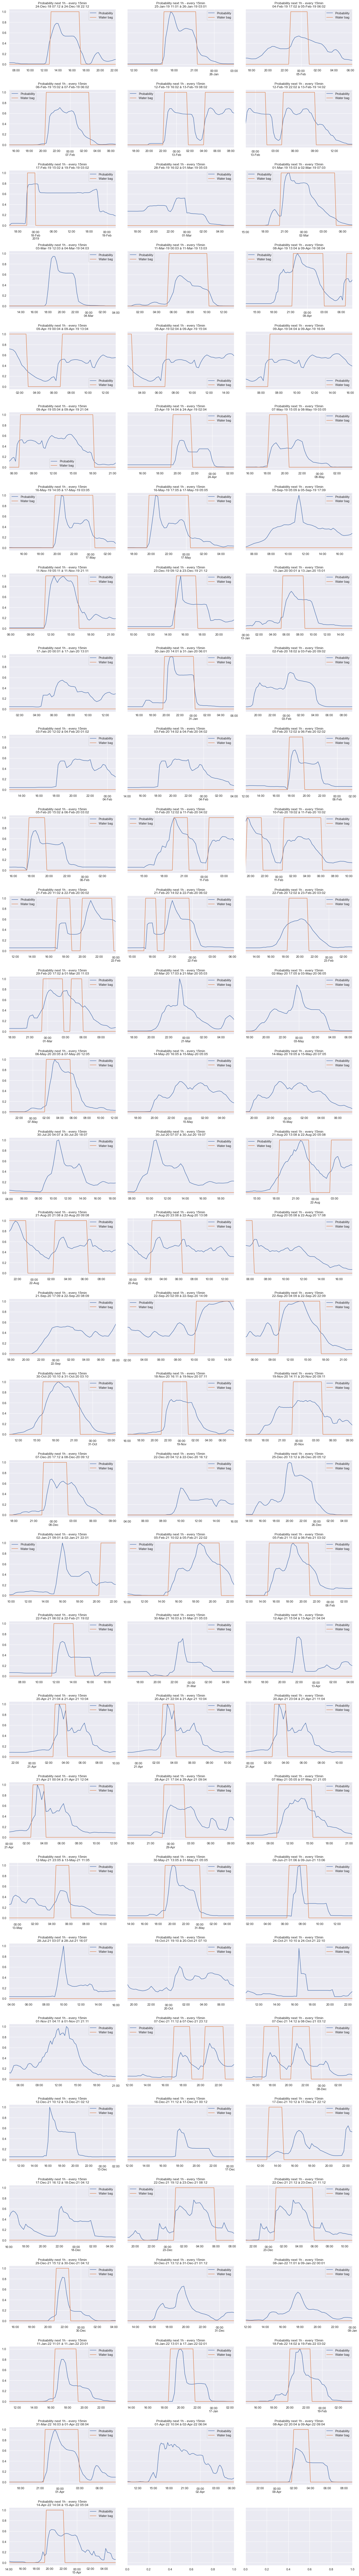

In [939]:
yhat_scl = (yprob_scl > 0.5).astype('int')

groups_hat = groupConsecutiveFlags(ts=yhat_scl)
groups_hat = 
windows =  groups_windows(groups_hat[groups_hat!=-1], spread=6, freq=pd.Timedelta(1, 'h'))

n_cols = 3
title = 'Probability next 1h - every 15min\n{} à {}'
path = 'Modelagem de Bolsões/Scores/Probabilidade Previsões.pdf'

fig, axs = multi_window_prob(
    ye_cv.to_frame('Water bag'),
    yprob_scl.to_frame('Probability'),
    windows, n_cols, title, path
)